In [1]:
import numpy as np
import os
import tensorflow as tf
import matplotlib
from dqn.DQNhistory import *
from dqn.DQNmodel import *
from dqn.DQNtrainer import Trainer
from unityagents import *
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


C:\Users\miguel\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
### General parameters
max_steps = 1e6 # Set maximum number of steps to run environment.
run_path = "dqn" # The sub-directory name for model and summary statistics
load_model = False # Whether to load a saved model.
train_model = True # Whether to train the model.
summary_freq = 10000 # Frequency at which to save training statistics.
save_freq = 50000 # Frequency at which to save model.
env_name = "dynamic_UFOGridWorld" # Name of the training environment file.
curriculum_file = None

### Algorithm-specific parameters for tuning
gamma = 0.99 # Reward discount rate.
num_layers = 2 # Number of hidden layers between state/observation encoding and value/policy layers.
epsilon_start = 0 # Initial probablity of random acction
epsilon_end = 0 # Final probability of random action
epsilon_decay_steps = 0 # Number of steps between epsilon_start and epsilon_end
pre_train_steps = 1e4 # Number of steps of random actions before first update
tau = 0.001 # Parameter that controls the update rate of the target model toward the main model
update_freq = 4 # Number of steps between model updates
replay_memory_size = 1e5 # Total size of replay memory
learning_rate = 3e-3 # Model learning rate.
hidden_units = 64 # Number of units in hidden layer.
batch_size = 64 # How many experiences per gradient descent update step.
normalize = False

### Logging dictionary for hyperparameters

hyperparameter_dict = {'max_steps':max_steps, 'run_path':run_path, 'env_name':env_name,
    'curriculum_file':curriculum_file, 'gamma':gamma, 'learning_rate':learning_rate,
    'hidden_units':hidden_units, 'batch_size':batch_size}

In [5]:
env = UnityEnvironment(file_name=env_name, curriculum=curriculum_file)
print(str(env))
brain_name = env.external_brain_names[0]

INFO:unityagents:
'UFOAcademy' started successfully!


Unity Academy name: UFOAcademy
        Number of brains: 1
        Reset Parameters :
		
Unity brain name: UFOBrain
        Number of observations (per agent): 0
        State space type: continuous
        State space size (per agent): 6
        Action space type: discrete
        Action space size (per agent): 4
        Memory space size (per agent): 0
        Action descriptions: , , , 


In [6]:
tf.reset_default_graph()

if curriculum_file == "None":
    curriculum_file = None


def get_progress():
    if curriculum_file is not None:
        if env._curriculum.measure_type == "progress":
            return steps / max_steps
        elif env._curriculum.measure_type == "reward":
            return last_reward
        else:
            return None
    else:
        return None

# Create the Tensorflow model graph
main = create_agent_model(env, lr=learning_rate,
                               h_size=hidden_units, max_step=max_steps, 
                               normalize=normalize, num_layers=num_layers)

target = create_agent_model(env, lr=learning_rate,
                               h_size=hidden_units, max_step=max_steps, 
                               normalize=normalize, num_layers=num_layers)

is_continuous = (env.brains[brain_name].action_space_type == "continuous")
use_observations = (env.brains[brain_name].number_observations > 0)
use_states = (env.brains[brain_name].state_space_size > 0)

model_path = './models/{}'.format(run_path)
summary_path = './summaries/{}'.format(run_path)

if not os.path.exists(model_path):
    os.makedirs(model_path)

if not os.path.exists(summary_path):
    os.makedirs(summary_path)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

epsilon = epsilon_start
if epsilon_decay_steps == 0:
    epsilon_decay = 0
else:
    epsilon_decay = (epsilon_start - epsilon_end)/epsilon_decay_steps
    
a_size = env.brains[brain_name].action_space_size
with tf.Session() as sess:
    # Instantiate model parameters
    if load_model:
        print('Loading Model...')
        ckpt = tf.train.get_checkpoint_state(model_path)
        saver.restore(sess, ckpt.model_checkpoint_path)
    else:
        sess.run(init)
    steps, last_reward = sess.run([main.global_step, main.last_reward])    
    summary_writer = tf.summary.FileWriter(summary_path)
    info = env.reset(train_mode=train_model, progress=get_progress())[brain_name]
    trainer = Trainer(main, target, sess, info, is_continuous, use_observations, use_states, replay_memory_size, train_model)
    if train_model:
        trainer.write_text(summary_writer, 'Hyperparameters', hyperparameter_dict, steps)
        tfVars = tf.trainable_variables()
        op_holder = trainer.update_target_graph(tfVars, tau)
        error = []
        episodes = 0
    while steps <= max_steps:
        if env.global_done:
            info = env.reset(train_mode=train_model, progress=get_progress())[brain_name]
            
        # Decide and take an action
        new_info = trainer.take_action(info, env, brain_name, steps, normalize, epsilon, a_size)
        info = new_info
        trainer.store_experiences(info)
        
        if steps > pre_train_steps and train_model: 
            
            if epsilon > epsilon_end:
                epsilon += - epsilon_decay
            
            if steps % update_freq == 0 and steps!= 0:
                # Perform gradient descent with experience buffer
                trainer.update_model(batch_size, gamma, epsilon, a_size)
                trainer.update_target(op_holder)
                #print('epsilon' + str(epsilon))
                #length = len(tfVars)
                #print(sess.run(tfVars[length//2 - 1]))
                #print(sess.run(tfVars[length - 1]))
        
#         # Plot weight difference
#         if info.local_done[0]:
#             v = sess.run(tfVars)
#             error.append(((v[1] - true)**2).mean())
#             episodes += 1
            
        if steps % summary_freq == 0 and steps != 0 and train_model:
            # Write training statistics to tensorboard.
            trainer.write_summary(summary_writer, steps, env._curriculum.lesson_number)
        if steps % save_freq == 0 and steps != 0 and train_model:
            # Save Tensorflow model
            save_model(sess, model_path=model_path, steps=steps, saver=saver)
        steps += 1
        sess.run(main.increment_step)
        if len(trainer.stats['cumulative_reward']) > 0:
            mean_reward = np.mean(trainer.stats['cumulative_reward'])
            sess.run(main.update_reward, feed_dict={main.new_reward: mean_reward})
            last_reward = sess.run(main.last_reward)
    # Final save Tensorflow model
    if steps != 0 and train_model:
        save_model(sess, model_path=model_path, steps=steps, saver=saver)
env.close()
export_graph(model_path, env_name)

Step: 10000. Mean Reward: -3.933203124999992. Std of Reward: 1.952405140778988.
Step: 20000. Mean Reward: -3.2371710526315733. Std of Reward: 2.2329949259149764.
Step: 30000. Mean Reward: -2.394387755102037. Std of Reward: 2.307489830754129.
Step: 40000. Mean Reward: -2.2941747572815503. Std of Reward: 2.142941687553815.
Step: 50000. Mean Reward: -2.1373786407766957. Std of Reward: 2.243736897320659.
Saved Model
Step: 60000. Mean Reward: -1.6527985074626843. Std of Reward: 2.0773524707566966.
Step: 70000. Mean Reward: -1.3858391608391587. Std of Reward: 2.1548369306996236.
Step: 80000. Mean Reward: -1.0118666666666654. Std of Reward: 1.8843847401443474.
Step: 90000. Mean Reward: -1.01824712643678. Std of Reward: 1.9747119903103947.
Step: 100000. Mean Reward: -0.82961956521739. Std of Reward: 1.9573836982630382.
Saved Model
Step: 110000. Mean Reward: -0.8937665782493355. Std of Reward: 1.9856867478617162.
Step: 120000. Mean Reward: -0.9515804597701134. Std of Reward: 2.0367927732092626.

Step: 990000. Mean Reward: 0.8800406641816333. Std of Reward: 0.1370334821699224.
Step: 1000000. Mean Reward: 0.8809580230196342. Std of Reward: 0.13285749258549587.
Saved Model
Saved Model
INFO:tensorflow:Restoring parameters from ./models/dqn\model-1000001.cptk


INFO:tensorflow:Restoring parameters from ./models/dqn\model-1000001.cptk


INFO:tensorflow:Froze 4 variables.


INFO:tensorflow:Froze 4 variables.


Converted 4 variables to const ops.


In [ ]:
print(len(trainer.training_buffer['actions']))
print(history_keys)

### Plotting Value Function for discrete state space

In [ ]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt 
V = np.zeros((4,4))
with tf.Session() as sess:
    ckpt = tf.train.get_checkpoint_state(model_path)
    saver.restore(sess, ckpt.model_checkpoint_path) 
    v = sess.run(tfVars)
    true = v[1]
    for i in range(4):
        for j in range(4):
            position = j + 4 * i;
            state = sess.run(main.state_onehot, {main.state_in: [[position]]})[0]
            V[i,j] = np.max(np.dot(state,v[1]))
            
            #V[i,j] = np.max(sess.run(main.predictions, {main.state_in: [[position]]})[0])            
V[3,2] = np.nan
V[1,3] = np.nan
colormap = plt.cm.cubehelix_r
fig, ax = plt.subplots(figsize=(8,6))
ax = sns.heatmap(V, annot=True, cmap="RdYlGn")
ax.invert_yaxis()

Text(0.5,0,'# Steps')

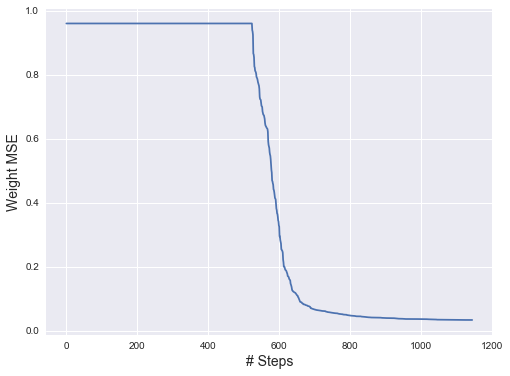

In [49]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(range(episodes),error, color="C0")
ax.set_ylabel("Weight MSE", fontsize=14)
ax.set_xlabel("# Steps", fontsize=14)

### Plotting Value Function for continuous state space
plot state value function (only for 2 dimensional state space)

### Contour Plot

INFO:tensorflow:Restoring parameters from ./models/dqn\model-300001.cptk


INFO:tensorflow:Restoring parameters from ./models/dqn\model-300001.cptk


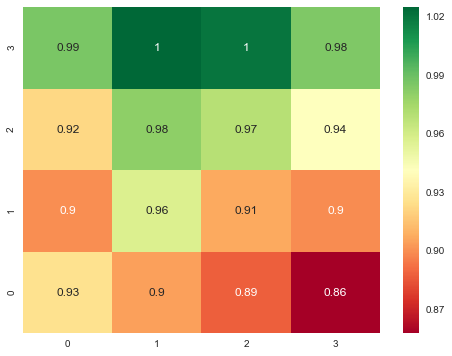

In [18]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt 
V = np.zeros((4,4))
with tf.Session() as sess:
    ckpt = tf.train.get_checkpoint_state(model_path)
    saver.restore(sess, ckpt.model_checkpoint_path) 
    v = sess.run(tfVars)
    true = v[1]
    for i in range(4):
        for j in range(4):
            
            V[i,j] = np.max(sess.run(main.predictions, {main.state_in: [[1/3*j,1/3*i]]})[0])  
            
colormap = plt.cm.cubehelix_r
fig, ax = plt.subplots(figsize=(8,6))
ax = sns.heatmap(V, annot=True, cmap="RdYlGn")
ax.invert_yaxis()


INFO:tensorflow:Restoring parameters from ./models/dqn\model-200001.cptk


INFO:tensorflow:Restoring parameters from ./models/dqn\model-200001.cptk


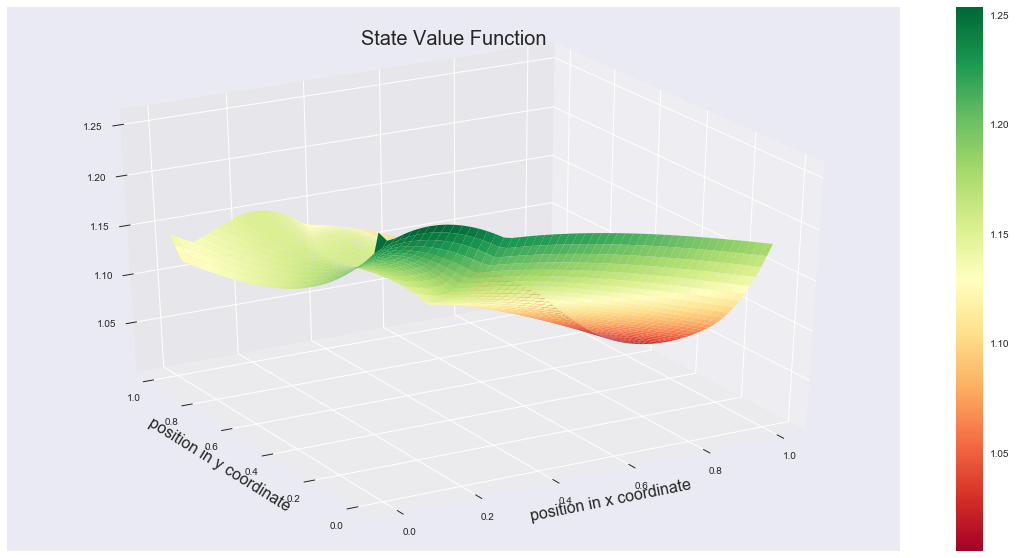

[[1.2594856  1.25051761 1.25155711 ... 1.18733382 1.18520057 1.18304515]
 [1.23761201 1.24149156 1.24421942 ... 1.17323029 1.17105079 1.16885006]
 [1.23132646 1.23523223 1.23790419 ... 1.1601342  1.15790617 1.15565836]
 ...
 [1.12964034 1.12676513 1.13029456 ... 1.02152717 1.01641083 1.01124883]
 [1.13742113 1.13255513 1.1296314  ... 1.02296257 1.01781368 1.01261723]
 [1.14529228 1.14048672 1.13581836 ... 1.02447748 1.01929665 1.01406682]]


In [6]:
V = np.zeros((50,50))
with tf.Session() as sess:
    ckpt = tf.train.get_checkpoint_state(model_path)
    saver.restore(sess, ckpt.model_checkpoint_path)        
    x_range = np.linspace(0, 1, 50)
    y_range = np.linspace(0, 1, 50)
    for i in range(len(x_range)):
        x = x_range[i]
        for j in range(len(y_range)):
            y = y_range[j]
            V[j,i] = np.max(sess.run(main.predictions, {main.state_in: [[x,y]]})[0]) 

X, Y = np.meshgrid(x_range, y_range)
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, V, rstride=1, cstride=1,
                       cmap="RdYlGn")
ax.set_title('State Value Function', fontsize=20)
ax.set_xlabel('position in x coordinate', fontsize=16)
ax.set_ylabel('position in y coordinate', fontsize=16)
ax.view_init(ax.elev, -120)
fig.colorbar(surf)
plt.show()
print(V)

<a list of 7 text.Text objects>

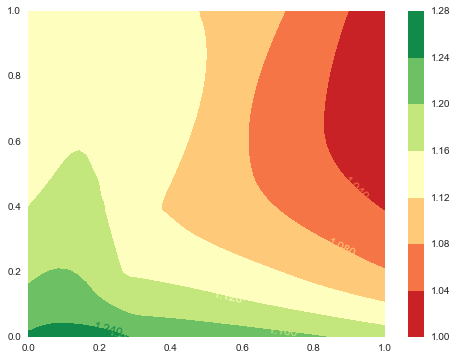

In [7]:
fig = plt.figure(figsize = (8,6))
CS = plt.contourf(X, Y, V, cmap="RdYlGn")
fig.colorbar(CS)
plt.clabel(CS, inline=False)